In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pycalphad.plot.triangular
import pycalphad.io.tdb_keywords
pycalphad.io.tdb_keywords.TDB_PARAM_TYPES.extend(['C11', 'C12', 'C44'])
from pycalphad.property_framework import ModelComputedProperty
from pycalphad import Database, Model, Workspace, variables as v
import numpy as np
import numpy.typing as npt
from tinydb import where
from typing import Dict, List

class ElasticModel(Model):
    def build_phase(self, dbe):
        super().build_phase(dbe)
        phase = dbe.phases[self.phase_name]
        param_search = dbe.search
        for prop in ['C11', 'C12', 'C44']:
            prop_param_query = (
            (where('phase_name') == phase.name) & \
            (where('parameter_type') == prop) & \
            (where('constituent_array').test(self._array_validity))
            )
            prop_val = self.redlich_kister_sum(phase, param_search, prop_param_query).subs(dbe.symbols)
            setattr(self, prop, prop_val)

class Moduli:
    implementation_units = 'GPa'
    display_units = 'GPa'

    def compute_property(self, compsets: List["CompositionSet"], cur_conds: Dict[str, float], chemical_potentials: npt.ArrayLike) -> npt.ArrayLike:
        if len(compsets) == 0:
            # this happens if the equilibrium conditions are infeasible
            return np.array([np.nan, np.nan, np.nan]) 
        c11 = ModelComputedProperty('C11').compute_property(compsets, cur_conds, chemical_potentials)
        c12 = ModelComputedProperty('C12').compute_property(compsets, cur_conds, chemical_potentials)
        c44 = ModelComputedProperty('C44').compute_property(compsets, cur_conds, chemical_potentials)

        cij = np.zeros((6,6))
        cij[0, 0] = cij[1, 1] = cij[2, 2] = c11
        cij[0, 1] = cij[1, 0] = cij[0, 2] = cij[2, 0] = cij[1, 2] = cij[2, 1] = c12
        cij[3, 3] = cij[4, 4] = cij[5, 5] = c44

        A_c = (cij[0, 0] + cij[1, 1] + cij[2, 2]) / 3.
        B_c = (cij[0, 1] + cij[0, 2] + cij[1, 2]) / 3.
        C_c = (cij[3, 3] + cij[4, 4] + cij[5, 5]) / 3.

        try:
            sij = np.linalg.inv(cij)
        except np.linalg.LinAlgError:
            return np.array([np.nan, np.nan, np.nan])
        A_s = (sij[0, 0] + sij[1, 1] + sij[2, 2]) / 3.
        B_s = (sij[0, 1] + sij[0, 2] + sij[1, 2]) / 3.
        C_s = (sij[3, 3] + sij[4, 4] + sij[5, 5]) / 3.

        Bv = (A_c + 2*B_c) / 3.
        Gv = (A_c - B_c + 3*C_c) / 5.
        Br = 1. / (3*A_s + 6*B_s)
        Gr = 5. / (4*A_s - 4*B_s + 3*C_s)
        Bvrh = (Br + Bv) / 2.
        Gvrh = (Gr + Gv) / 2.
        Yvrh = (9*Bvrh*Gvrh) / (Gvrh + 3*Bvrh)
        # bulk, shear, Young
        return np.array([Bvrh, Gvrh, Yvrh])

    @property
    def shape(self):
        return (3,)

In [2]:
dbf = Database('ElasticTi.tdb')
wks = Workspace(dbf, ['TI', 'MO', 'NB', 'VA'], 'BCC_A2', models={'BCC_A2': ElasticModel})
wks.conditions = {v.T: 300, v.P: 1e5, v.N: 1,
                  v.X('MO'): (0, 1, 0.01),
                  v.X('NB'): (0, 1, 0.01)}
X, Y, moduli = wks.get('X(MO)', 'X(NB)', Moduli())

bulk_modulus = moduli[..., 0]
shear_modulus = moduli[..., 1]
young_modulus = moduli[..., 2]

Text(0.5, 1.0, 'Bulk modulus')

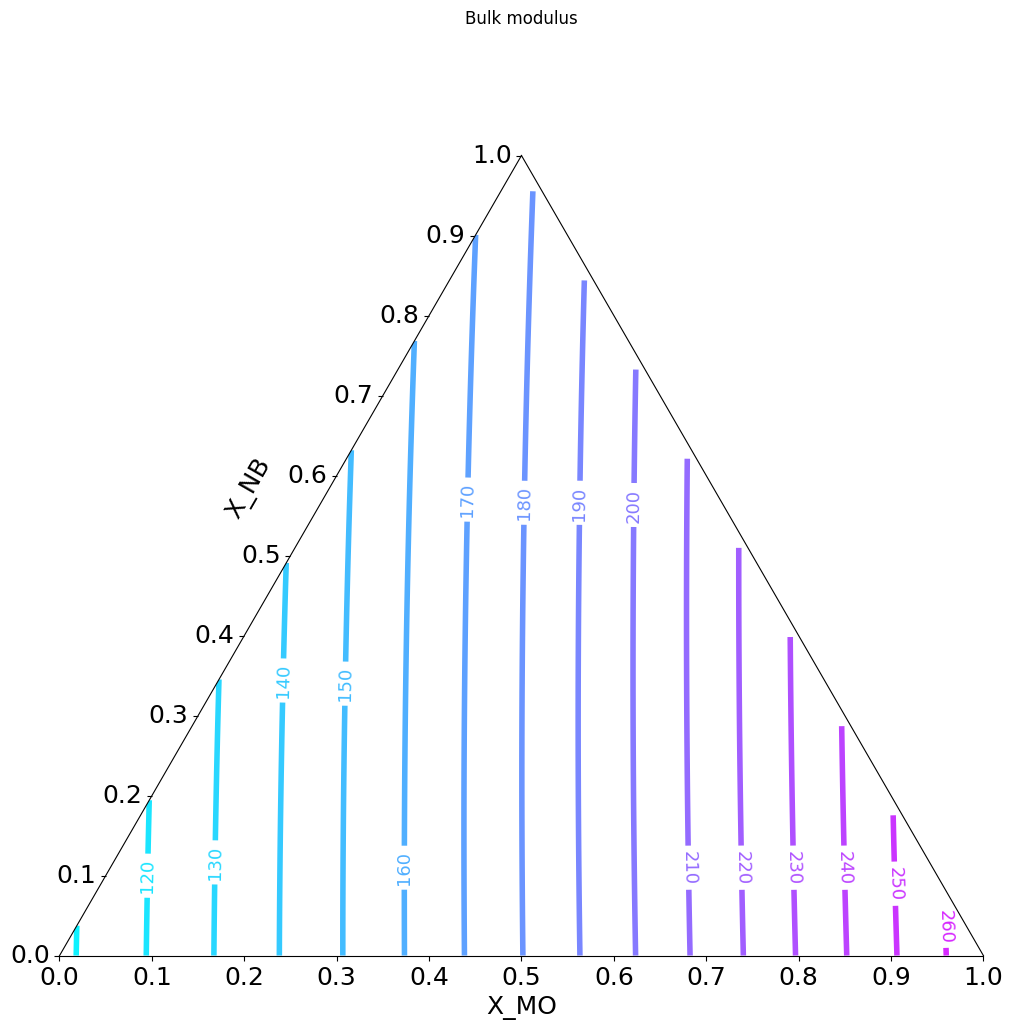

In [3]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(projection='triangular')
CS = ax.contour(X, Y, bulk_modulus, linewidths=4, levels=list(range(100, 300, 10)), cmap='cool')
ax.clabel(CS, inline=1, fontsize=13, fmt='%1.0f')
#PCM=ax.get_children()[0] #get the mappable, the 1st and the 2nd are the x and y axes
#plt.colorbar(PCM, ax=ax)
ax.set_xlabel(wks.condition_axis_order[0], fontsize=18)
ax.set_ylabel(wks.condition_axis_order[1], fontsize=18, rotation=60, labelpad=-180)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
ax.set_title('Bulk modulus')
#fig.savefig('TiMoNb-Bulk.pdf')

Text(0.5, 1.0, 'Shear modulus')

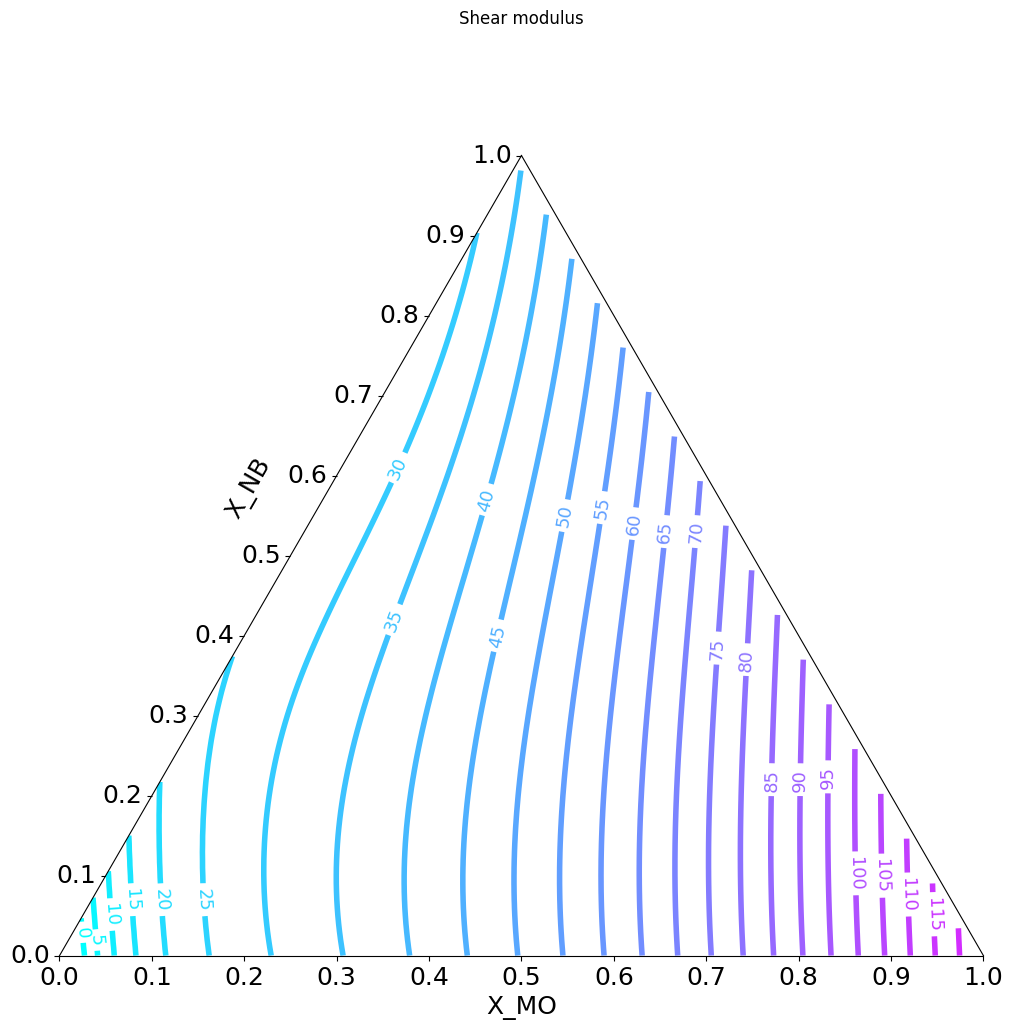

In [4]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(projection='triangular')
CS = ax.contour(X, Y, shear_modulus, linewidths=4, levels=list(range(0, 150, 5)), cmap='cool')
ax.clabel(CS, inline=1, fontsize=13, fmt='%1.0f')
#PCM=ax.get_children()[0] #get the mappable, the 1st and the 2nd are the x and y axes
#plt.colorbar(PCM, ax=ax)
ax.set_xlabel(wks.condition_axis_order[0], fontsize=18)
ax.set_ylabel(wks.condition_axis_order[1], fontsize=18, rotation=60, labelpad=-180)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
ax.set_title('Shear modulus')
#fig.savefig('TiMoNb-Shear.pdf')

Text(0.5, 1.0, "Young's modulus")

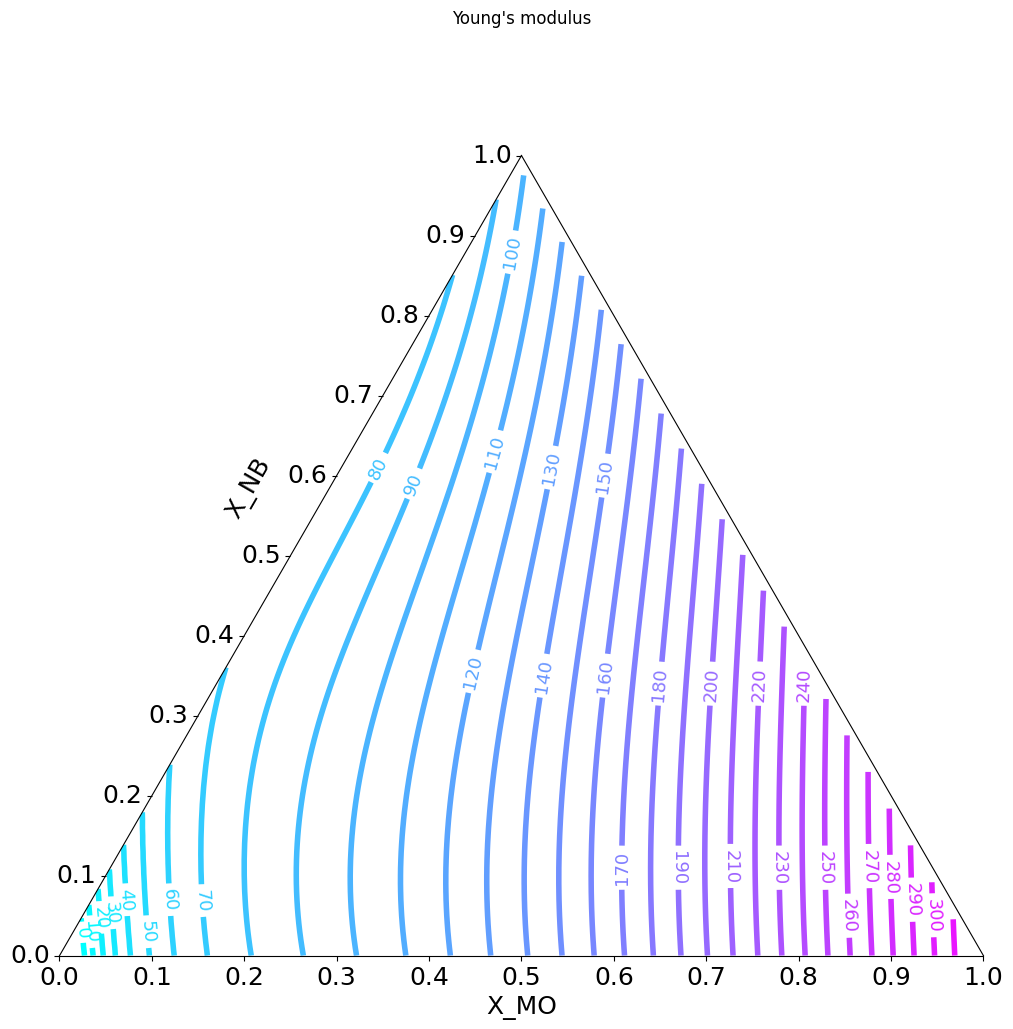

In [5]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(projection='triangular')
CS = ax.contour(X, Y, young_modulus, linewidths=4, levels=list(range(0, 350, 10)), cmap='cool')
ax.clabel(CS, inline=1, fontsize=13, fmt='%1.0f')
#PCM=ax.get_children()[0] #get the mappable, the 1st and the 2nd are the x and y axes
#plt.colorbar(PCM, ax=ax)
ax.set_xlabel(wks.condition_axis_order[0], fontsize=18)
ax.set_ylabel(wks.condition_axis_order[1], fontsize=18, rotation=60, labelpad=-180)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
ax.set_title('Young\'s modulus')
#fig.savefig('TiMoNb-Young.pdf')

In [6]:
ti_db = Database('Ti-working database_v2_3_23_2017.tdb')
wks_ti = Workspace(ti_db, ['TI', 'MO', 'NB', 'VA'])
wks_ti.conditions.update(wks.conditions) # use the same conditions as above

class IsSinglePhase:
    implementation_units = '' # dimensionless
    display_units = ''

    def __init__(self, phase_name: str):
        self.phase_name = phase_name.upper()

    def compute_property(self, compsets: List["CompositionSet"], cur_conds: Dict[str, float], chemical_potentials: npt.ArrayLike) -> npt.ArrayLike:
        return float((len(compsets) == 1) and \
                     (compsets[0].phase_record.phase_name == self.phase_name))

    @property
    def shape(self):
        return tuple()

# range of modulii of interest
min_modulus = 10
max_modulus = 50
# only consider single-phase bcc regions
stability_mask = np.nonzero(wks_ti.get(IsSinglePhase('BCC_B2'))[0])
filtered_young_modulus = np.array(young_modulus)
filtered_young_modulus[stability_mask] = np.nan
filtered_young_modulus[filtered_young_modulus < min_modulus] = np.nan
filtered_young_modulus[filtered_young_modulus > max_modulus] = np.nan

Text(0.5, 1.0, "Young's modulus")

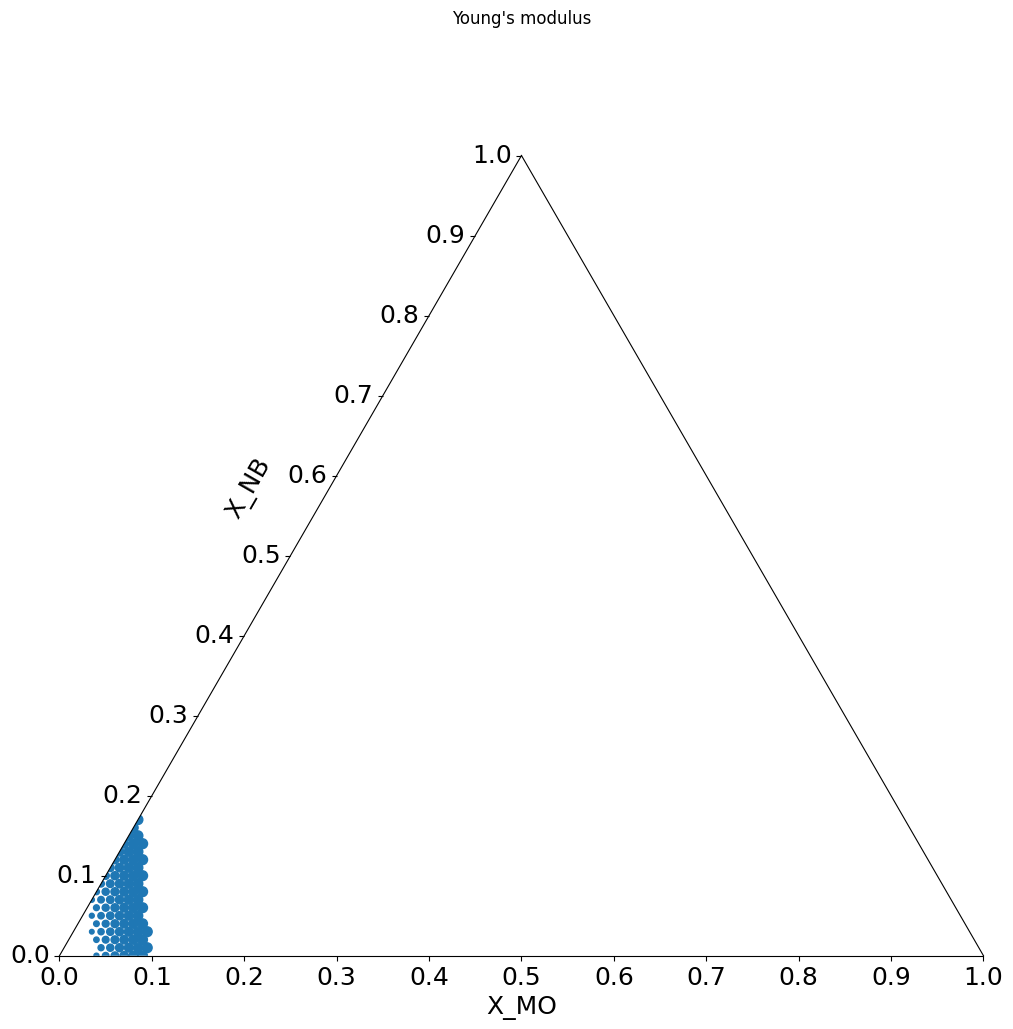

In [7]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(projection='triangular')
CS = ax.scatter(X, Y, filtered_young_modulus)
ax.set_xlabel(wks.condition_axis_order[0], fontsize=18)
ax.set_ylabel(wks.condition_axis_order[1], fontsize=18, rotation=60, labelpad=-180)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
ax.set_title('Young\'s modulus')
#fig.savefig('TiMoNb-Young.pdf')
